We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [56]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

## Tools

In [5]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)
    N = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [ ]:
"""
    plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)

plot predictions versus the given test set, when TDE is performed seperately on different observables
"""
function plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)
    
    prediction_x = esn_x(Generative(size(test_data_x, 2)), W_x)
    prediction_y = esn_y(Generative(size(test_data_y, 2)), W_y)
    prediction_z = esn_z(Generative(size(test_data_z, 2)), W_z)
    
    label = ["actual" "predicted"]
    times_x = Δt * collect(0:size(test_data_x, 2))[1:end-1] / λ_max
    times_y = Δt * collect(0:size(test_data_y, 2))[1:end-1] / λ_max
    times_z = Δt * collect(0:size(test_data_z, 2))[1:end-1] / λ_max

    p1 = plot(times_x, [test_data_x[1, :], prediction_x[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times_y, [test_data_y[1, :], prediction_y[1, :]], label = label, ylabel = "y(t)")
    p3 = plot(times_z, [test_data_z[1, :], prediction_z[1, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction_tde_sep

In [93]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction

## TDE on each observable seperately

we perform a TDE of a 1D observation of the Lorenz System

In [76]:
# set up hyperparameters for grid search
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08, 0.1, 0.12, 0.14]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [60, 100, 110,150, 160, 180, 190, 200]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);


In [38]:
# perform TDE on x_data 
x_data_emb, τ, E = optimal_separated_de(data[1,:])
y_data_emb, τ, E = optimal_separated_de(data[2,:])
z_data_emb, τ, E = optimal_separated_de(data[3,:]);

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [39]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)
train_y_data_emb, val_y_data_emb, test_y_data_emb = train_val_test_split(Matrix(y_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)
train_z_data_emb, val_z_data_emb, test_z_data_emb = train_val_test_split(Matrix(z_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)


([12.6247785422481 30.07786032572417 … 28.14568611771744 21.522575121534754; 41.07841787600913 30.780402779471885 … 17.114447198138084 15.258220632264873; … ; 16.502536637180473 20.044567854204193 … 36.376426533518455 28.574823185043257; 31.979135599053777 35.83872682427738 … 21.88201025199257 16.868928228046812], [17.114447198138084 15.258220632264873 … 21.478575646841787 16.850366580689567; 19.443123490027656 33.05809540613175 … 14.110654878348956 15.596105795509356; … ; 21.88201025199257 16.868928228046812 … 31.58149118237152 23.90747168761088; 13.24538993283178 11.545980665361556 … 18.275694375991304 13.996299828890779], [14.110654878348956 15.596105795509356 … 12.037786751097213 10.620382885952568; 27.713938865858378 38.59689745202367 … 15.366632719433627 34.5194245664989; … ; 18.275694375991304 13.996299828890779 … 22.025916705088807 17.452245471384494; 10.722480557514908 8.226272781471462 … 15.33656129931328 18.844711140170656])

In [41]:
esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid)


enso_project.ESNHyperparams(140, 0.8, 0.05, 0.1, 0.0)
Validation loss = 24739.564746338983
enso_project.ESNHyperparams(170, 0.8, 0.05, 0.1, 0.0)
Validation loss = 22992.450110774007
enso_project.ESNHyperparams(150, 0.8, 0.08, 0.1, 0.0)
Validation loss = 17384.634405069373
enso_project.ESNHyperparams(180, 0.9, 0.08, 0.1, 0.0)
Validation loss = 11170.665885168371
enso_project.ESNHyperparams(180, 0.9, 0.08, 0.1, 1.0e-6)
Validation loss = 7692.185165825643


(ESN(3 => 180), OutputLayer successfully trained with output size: 3, 7692.185165825643)

In [42]:
esn_y_emb, W_out_y_emb, val_loss_y_emb = enso_project.cross_validate_esn(train_y_data_emb, val_y_data_emb, param_grid)


enso_project.ESNHyperparams(140, 0.8, 0.05, 0.1, 0.0)
Validation loss = 117564.57657772682
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 65718.75265231273
enso_project.ESNHyperparams(210, 0.9, 0.05, 0.1, 0.0)
Validation loss = 64712.25850691457
enso_project.ESNHyperparams(180, 1.0, 0.05, 0.1, 0.0)
Validation loss = 57750.02709337369
enso_project.ESNHyperparams(210, 0.8, 0.08, 0.1, 0.0)
Validation loss = 40898.82219320314
enso_project.ESNHyperparams(180, 0.9, 0.08, 0.1, 1.0e-5)
Validation loss = 33135.008875152314


(ESN(4 => 180), OutputLayer successfully trained with output size: 4, 33135.008875152314)

In [ ]:
esn_z_emb, W_out_z_emb, val_loss_z_emb = enso_project.cross_validate_esn(train_z_data_emb, val_z_data_emb, param_grid)
# reduce reservoir size in grid in this case

enso_project.ESNHyperparams(50, 0.8, 0.05, 0.1, 0.0)
Validation loss = 2.9295059330975024e11
enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
Validation loss = 5.113877600525403e8
enso_project.ESNHyperparams(70, 0.9, 0.05, 0.1, 0.0)
Validation loss = 103666.71589982788
enso_project.ESNHyperparams(110, 0.8, 0.08, 0.1, 0.0)
Validation loss = 57660.649798774015
enso_project.ESNHyperparams(60, 1.0, 0.05, 0.5, 0.0)
Validation loss = 51263.25884215944
enso_project.ESNHyperparams(60, 0.8, 0.1, 0.5, 0.0)
Validation loss = 48843.60943418205
enso_project.ESNHyperparams(60, 0.9, 0.1, 0.5, 0.0)
Validation loss = 48029.554788244764
enso_project.ESNHyperparams(60, 1.0, 0.1, 0.5, 1.0e-6)
Validation loss = 48013.35657768177
enso_project.ESNHyperparams(60, 1.0, 0.05, 1.0, 1.0e-6)
Validation loss = 47341.8730336446
enso_project.ESNHyperparams(60, 0.9, 0.1, 2.0, 1.0e-6)
Validation loss = 41703.03228316797


(ESN(5 => 60), OutputLayer successfully trained with output size: 5, 41703.03228316797)

## ESN training without TDE

In [75]:
x_data_1D = data[:,1:length(x_data_emb)]
train_data_1D, val_data_1D, test_data_1D = train_val_test_split(x_data_1D; val_seconds= 15* l_max, test_seconds =15* l_max)

([-7.9554025169651865 -15.346598018787718 … -9.611377124950293 -14.149548893578913; -14.531571567037844 -21.015432073057987 … -15.212607369731359 -15.608439389094631; 12.6247785422481 30.07786032572417 … 19.443123490027656 33.05809540613175], [-10.638861349658093 -4.332534432311105 … -13.477984779336781 -13.21770933483036; -3.6405752334315 0.21198582612010525 … -18.416932009575458 -7.2585701948225285; 36.376426533518455 28.574823185043257 … 27.713938865858378 38.59689745202367], [-5.790194667320335 -1.505872934191586 … -11.024914402851575 -2.524607876341493; 0.7830908079736009 0.804780049820736 … -1.0053821530517506 3.221580243680637; 31.58149118237152 23.90747168761088 … 38.98236887753309 28.899901713543642])

In [77]:
# network training
esn_1D, W_out_1D, val_loss_1D = enso_project.cross_validate_esn(train_data_1D, val_data_1D, param_grid)

enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
Validation loss = 193283.83413143252
enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
Validation loss = 59057.84427239245
enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 28357.319883649816
enso_project.ESNHyperparams(200, 0.8, 0.05, 0.1, 0.0)
Validation loss = 25711.2249684477
enso_project.ESNHyperparams(160, 0.9, 0.05, 0.1, 0.0)
Validation loss = 7079.418886576852


(ESN(3 => 160), OutputLayer successfully trained with output size: 3, 7079.418886576852)

## Comparison

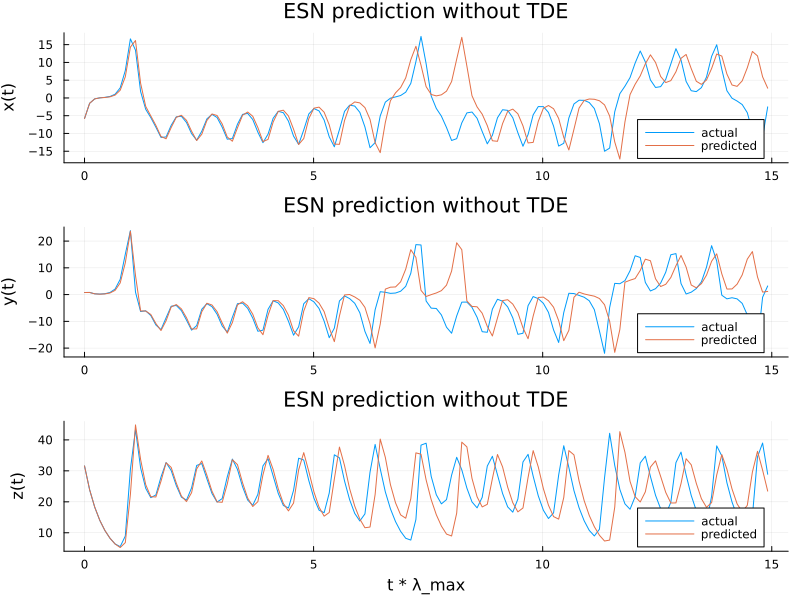

In [95]:
plot_prediction(esn_1D, W_out_1D, test_data_1D, l_max, "ESN prediction without TDE")

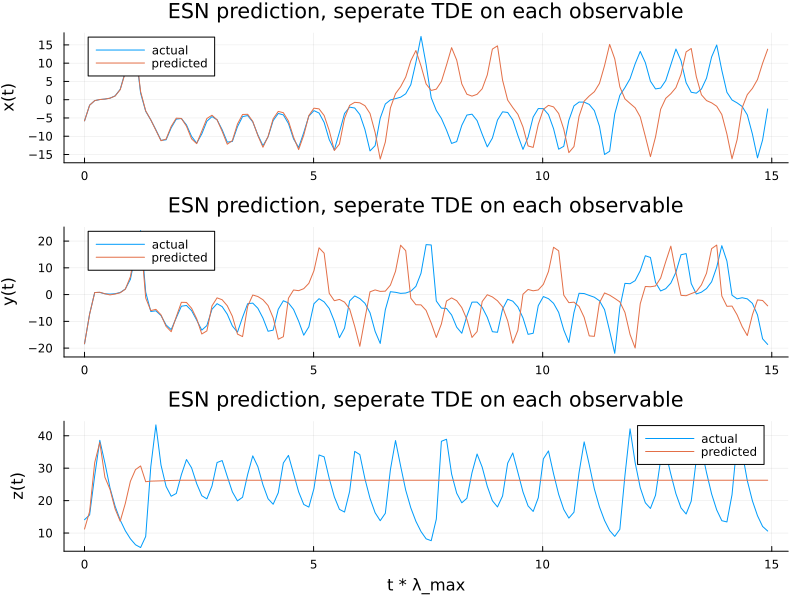

In [94]:
plot_prediction_tde_sep(esn_x_emb, esn_y_emb,esn_z_emb, W_out_x_emb,W_out_y_emb, W_out_z_emb, test_x_data_emb,test_y_data_emb,test_z_data_emb, l_max, "ESN prediction, seperate TDE on each observable")

The prediction without TDE is seemingly better.

## More dimensional